## Multi-label classification

Multi-label classification describes the situation where each image belongs in more than one class. This type of classification problem is a little closer to the complex image processing we'd probably like to be able to do. :-)

### Set up our environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#fastai imports
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

**Identify our dataset**

Can you train your network on the Kaggle planet data competition? Absolutely!

However, you'll find that you learn more and enjoy your learning more if you use datasets that are interesting to you, datasets that you can get excited about!

Do you consider yourself a foodie? The [Yelp](https://www.kaggle.com/c/yelp-restaurant-photo-classification/data) contest dataset might be fun to play with.

Are you interested in image processing traffic information for self-driving cars? The [LISA traffic sign dataset](http://cvrr.ucsd.edu/LISA/lisa-traffic-sign-dataset.html) might be interesting.



**Set up our data for training**

For single-label classification, we organized images into folders, and the folder names provided our labels.

For multi-label classification, we're going to put all of our images in the same folder, and we'll get our labels from a csv file. The csv file has two columns: image name, image labels (image labels is a space-delimited list).

In [4]:
PATH = '../../../data/dogbreed/'
# !ln -s {PATH} dogbreed # symlink because these paths are bananas
!ls ./dogbreed
PATH = './dogbreed/'

labels.csv	sample_submission.csv.zip  test.zip  train-jpg
labels.csv.zip	test-jpg		   tmp	     train.zip


In [5]:
#display a list of the folders that are in your data path
# !mv {PATH}test {PATH}test-jpg
# !mv {PATH}train {PATH}train-jpg
!ls {PATH}
#expected result: test-jpg/  train-jpg/ <YOUR LABELS FILE>.csv (other folders are permissible, these are required)

labels.csv	sample_submission.csv.zip  test.zip  train-jpg
labels.csv.zip	test-jpg		   tmp	     train.zip


In [6]:
size = 224 # 224x224 image training
architecture = resnext50
#set the path to our labels file
label_csv = f'{PATH}labels.csv'
!head {label_csv}

id,breed
000bec180eb18c7604dcecc8fe0dba07,boston_bull
001513dfcb2ffafc82cccf4d8bbaba97,dingo
001cdf01b096e06d78e9e5112d419397,pekinese
00214f311d5d2247d5dfe4fe24b2303d,bluetick
0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
002a283a315af96eaea0e28e7163b21b,borzoi
003df8b8a8b05244b1d920bb6cf451f9,basenji


In [7]:
n = len(list(open(label_csv))) - 1 # number of records we're dealing with
# define our validation dataset right away with "get cross-validation indexes"
validation_indexs = get_cv_idxs(n) # it's 20% btw
print(validation_indexs)
print(n)

[2882 4514 7717 ... 8922 6774   37]
10222


In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


## Multi-label classification

In [11]:
#create a handy function that retrieves the
#first file from a given path
def get_1st(path:str): 
    return glob(f'{path}/*.*')[0]

### Multi-label

Use this week's multi-label dataset to display 2 images and their labels. We're not doing any code-based lookup here, just hardcoding image values.

In [12]:
dog_sample_1 = f"{PATH}train-jpg/ae8693b4868b1744be1fefb328a8a486.jpg"
dog_sample_2 = f"{PATH}train-jpg/dd1d181a7224fa5a1a7c1fae05eec93d.jpg"
list_paths = [dog_sample_1, dog_sample_2]
titles=["Bulldog (?)", "St. Bernard(?)"]
# plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for our dataset

You might find these references handy when coding your own network:
- ImageClassifierData object defined in [fastai/dataset.py](https://github.com/fastai/fastai/blob/master/fastai/dataset.py). We'll access functions like resize() through this object.

---
I'm leaving the template at this point because it seems to be guiding me much in the same way Udacity's Deep Learning Nanodegree did.
* That's not what I'm looking for anymore. I need intuition, not hand-holding
* Jeremy is guiding the implementation, and I'm taking notes of his mentoring.

I appreciate the template's attempts to lead us to modular code designs (e.g. functions for reproducibility),
  but the questions are un-helpfully abstract

---

## Transforming our dataset

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [13]:
def get_transforms(sz):
    #YOUR CODE HERE
    tfms = tfms_from_model(architecture, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return tfms


def get_data(sz, batch_size=64)-> ImageClassifierData:
    path=PATH
    trainfolder='train-jpg'
    _label_csv=label_csv
    suffix='.jpg'
    val_idxs=validation_indexs
    testfolder='test-jpg'
    
    transforms = get_transforms(sz)
    data = ImageClassifierData.from_csv(PATH, trainfolder, _label_csv, test_name=testfolder,
                                        suffix=suffix, val_idxs=val_idxs, tfms=transforms, bs=batch_size)
    return data if sz > 300 else data.resize(340, 'tmp')

In [14]:
#get the fastai.dataset.ImageClassifierData object for the transforms from our label_csv
data = get_data(256)

In [15]:
#take a peek at our data
# x,y = next(iter(data.val_dl))

In [16]:
# y

I highjacked this line of code from the template. Seeing as I've already imported the data, this should be 
the first index that a given breed was found

Be sure that you understand what this code is doing!

In [17]:
# african_hunting_dog_id = label_df.iloc[7, :].id
# test_img = PIL.Image.open(f"{PATH}train-jpg/{african_hunting_dog_id}.jpg"); test_img

In [18]:
# test_img.close()

---
Comparing Jeremy's work with the template:
* At this point, Jeremy does some cursory investigation into the dataset that he has just to make sure he can model
  the dang thing
* The notebook suggests steps, but leaves out the reasoning behind __any of it__
  - Loss in points for that one.
* Also, the next few boxes involve loading the data for a second time, which seems random to me when Jeremy advised
  against loading the data at size 64px because it changes the problem you're solving

---

In [19]:
# file_first = PATH+ data.trn_ds.fnames[0]
# file_first

In [20]:
# img = PIL.Image.open(file_first); img

In [21]:
# img.size; img.close()

In [22]:
# jeremy recommends a dictionary comprehension of a filename -> file size
# size_d = {fname: PIL.Image.open(PATH + fname) for fname in data.trn_ds.fnames}

I'm not too high-minded to think that the handful of times that I've made a histogram with Pandas, Matploblib
  makes me an expert here
* But having seen the data already makes we work to skip this error...

I'll re-run the stuff so that I prove to myself that I'm not a quitter

---

I've spent an hour trying to work through his EDA when I don't particularly care about this dataset.
* That's a logical flub if ever there was one.

Now let's transform some of our data by resizing it

In [23]:
# sz=64 #this is the value used by Jeremy

In [24]:
# data = get_data(sz)

In [25]:
# multiplier=1.3 #this is the value used by Jeremy
# newsize=int(sz*multiplier)
# tempfolder='tmp'

In [26]:
# data = #YOUR CODE HERE

In [27]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [28]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Training our model

Instantiate the learn variable with a pre-trained model

In [29]:
# !cd fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz

In [30]:
# let's make a model
learn = ConvLearner.pretrained(architecture, data, precompute=True)

Let's see what the pretrained model can tell us about it's learning rate

 94%|█████████▍| 120/128 [00:19<00:01,  7.59it/s, loss=5.81]

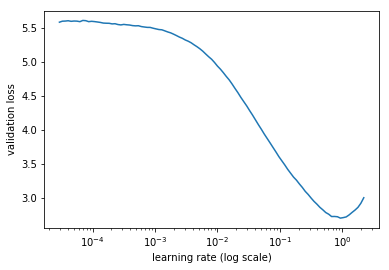

In [31]:
lrf=learn.lr_find()
learn.sched.plot()

We're going to hard code a learning rate based on the results we see above.

Something to think about...would it be handy to have a function that sets the learning rate for us? Can you code that function?

In [53]:
learningrate = 1e-2

We can make this whole thing a reproduction function

In [36]:
learn.fit(learningrate, 3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.709794   0.33       0.898239  
    1      0.357176   0.310553   0.902642                    
    2      0.245655   0.316128   0.900196                    


[array([0.31613]), 0.9001956951828152]

In [54]:
learn = ConvLearner.pretrained(architecture, data, precompute=True, ps=0.5)
learn.fit(learningrate, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.379487   0.516348   0.882094  
    1      0.62909    0.369772   0.900196                    


[array([0.36977]), 0.9001956943663132]

So $10^{-2}$ is better

In [55]:
print("\nStarting data augmented execution\n")
learn.precompute = False
learn.fit(learningrate, 3, cycle_len=1)


Starting data augmented execution



epoch      trn_loss   val_loss   accuracy                    
    0      0.531539   0.335304   0.906067  
    1      0.47451    0.313982   0.911448                    
    2      0.430355   0.307596   0.907534                    


[array([0.3076]), 0.9075342457588405]

In [56]:
learn.save(f'{size}')

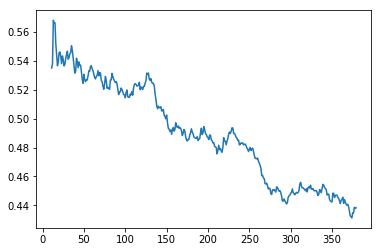

In [57]:
learn.sched.plot_loss() # keeping track of what's going on

In [59]:
learn.set_data(get_data(299, batch_size=28))

In [60]:
learn.freeze()

In [61]:
learningrates = np.array([learningrate/9,learningrate/3,learningrate])

In [62]:
learn.fit(learningrates, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.488593   0.289888   0.91683   
    1      0.461056   0.283439   0.916341                    
    2      0.410948   0.273755   0.915362                    


[array([0.27376]), 0.9153620323089704]

In [63]:
learn.save(f'{size}_differentiated') # persist our training

In [71]:
def present_accuracies(learner):
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)

    total_accuracy, overall_loss = accuracy_np(probs, y), metrics.log_loss(y, probs)
    
    print(f"Accuracy: {total_accuracy}")
    print(f"Loss: {overall_loss}")

Now, let's use the learning rates array to add to our training

In [64]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.421295   0.276549   0.911448  
    1      0.461746   0.277357   0.908513                    
    2      0.327836   0.264483   0.914873                    
    3      0.367536   0.277318   0.90998                     
    4      0.334515   0.275589   0.90998                     
    5      0.277594   0.267126   0.90998                     
    6      0.275299   0.266005   0.912427                    


[array([0.26601]), 0.9124266113320442]

In [72]:
present_accuracies(learn)

Accuracy: 0.9178082191780822                 
Loss: 0.2619643751170404


We need a function that takes a ConvLearner object, a data size, a learning rate, and a learning rate array. The function should perform the following tasks on the learner object:
- set the model data to a ImageClassifierData created with the given data size (hint: we have a get_data function)
- use the given learning rate to train the ConvLearner object
- use the given learning rate array to train the ConvLearner object
- save the ConvLearner object

The function should return the updated ConvLearner object.

Hint: don't forget about freezing and unfreezing!

In [ ]:
def update_learner(learner,sz,lr,lrs):
    learner.set_data(get_data(sz, batch_size=32))
    learner.freeze()
    learner.fit(lr, 2, cycle_len=1)
    learner.fit(lrs, 3, cycle_len=1)
    
    return learner

In [ ]:
sz=128
update_learner(learn,sz,learningrate,learningrates)

In [ ]:
sz=256
update_learner(learn,sz,learningrate,learningrates)

Let's take a look at what our model has learned

In [ ]:
learn.save(f'{sz}')

### End